In [37]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)


In [38]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
real_backend = provider.get_backend('ibmq_belem')
print("backend used: ", real_backend)

ibmqfactory.load_account:WARNING:2022-12-08 16:54:44,651: Credentials are already in use. The existing account in the session will be replaced.


backend used:  ibmq_belem


In [39]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [40]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

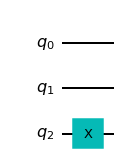

In [36]:
n = 2
oracle_qc = dj_oracle('constant', n)
oracle_qc.draw()

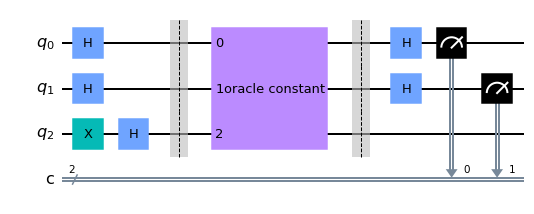

In [37]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

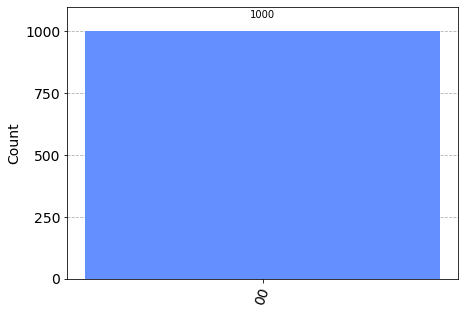

In [13]:
aer_backend = Aer.get_backend('aer_simulator')
job = execute(dj_circuit, aer_backend, shots=1000)
sim_results = job.result()
counts = sim_results.get_counts()
plot_histogram(counts)

In [ ]:
job = execute(dj_circuit, real_backend, shots=1000)
job_monitor(job, interval=2)

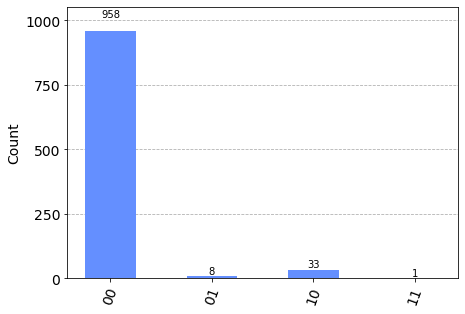

In [10]:
# Get the results of the computation
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

In [10]:
qr = QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_results = real_backend.run(meas_calibs, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [16]:
aer_simulator = Aer.get_backend('aer_simulator')

In [17]:
qr = QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_results = aer_simulator.run(meas_calibs, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [14]:
n

2

In [65]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

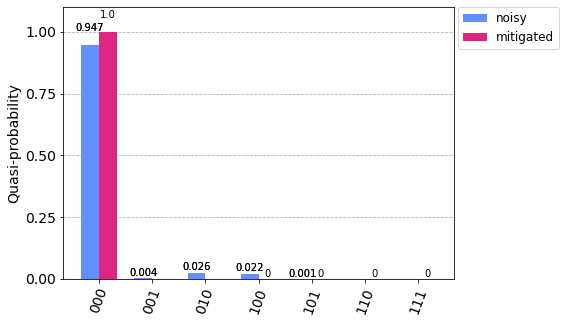

In [66]:
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

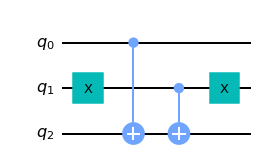

In [8]:
oracle_qc = dj_oracle('balanced', n)
oracle_qc.draw()

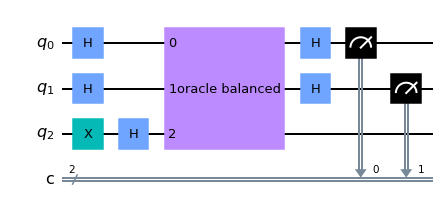

In [9]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

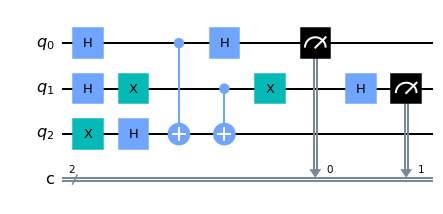

In [10]:
new_dj = dj_circuit.decompose('oracle balanced')

new_dj.draw()

In [11]:
dj1f = QuantumCircuit(n)
dj2f = QuantumCircuit(n)
dj2f.x(1)
dj3f = QuantumCircuit(n)
dj3f.x(0)
dj4f = QuantumCircuit(n)
dj4f.x(0)
dj4f.x(1)

dj1s = QuantumCircuit(n)
dj2s = QuantumCircuit(n)
dj2s.x(1)
dj3s = QuantumCircuit(n)
dj3s.x(0)
dj4s = QuantumCircuit(n)
dj4s.x(0)
dj4s.x(1)

In [12]:
for circuit in [dj1f, dj2f, dj3f, dj4f]:
    circuit.h(0)
    circuit.h(1)
    circuit.x(1)
    circuit.x(1)
    circuit.h(1)
    circuit.h(0)
for circuit in [dj1f, dj2f, dj3f, dj4f]:
    print(circuit)

     ┌───┐┌───┐          
q_0: ┤ H ├┤ H ├──────────
     ├───┤├───┤┌───┐┌───┐
q_1: ┤ H ├┤ X ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘
     ┌───┐┌───┐               
q_0: ┤ H ├┤ H ├───────────────
     ├───┤├───┤┌───┐┌───┐┌───┐
q_1: ┤ X ├┤ H ├┤ X ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘
     ┌───┐┌───┐┌───┐     
q_0: ┤ X ├┤ H ├┤ H ├─────
     ├───┤├───┤├───┤┌───┐
q_1: ┤ H ├┤ X ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘
     ┌───┐┌───┐┌───┐          
q_0: ┤ X ├┤ H ├┤ H ├──────────
     ├───┤├───┤├───┤┌───┐┌───┐
q_1: ┤ X ├┤ H ├┤ X ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘


In [13]:
for circuit in [dj1s, dj2s, dj3s, dj4s]:
    circuit.x(1)
    circuit.h(0)
    circuit.h(1)
    
    circuit.h(1)
    circuit.h(0)
    circuit.x(1)
for circuit in [dj1s, dj2s, dj3s, dj4s]:
    print(circuit)

     ┌───┐┌───┐          
q_0: ┤ H ├┤ H ├──────────
     ├───┤├───┤┌───┐┌───┐
q_1: ┤ X ├┤ H ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘
     ┌───┐┌───┐               
q_0: ┤ H ├┤ H ├───────────────
     ├───┤├───┤┌───┐┌───┐┌───┐
q_1: ┤ X ├┤ X ├┤ H ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘
     ┌───┐┌───┐┌───┐     
q_0: ┤ X ├┤ H ├┤ H ├─────
     ├───┤├───┤├───┤┌───┐
q_1: ┤ X ├┤ H ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘
     ┌───┐┌───┐┌───┐          
q_0: ┤ X ├┤ H ├┤ H ├──────────
     ├───┤├───┤├───┤┌───┐┌───┐
q_1: ┤ X ├┤ X ├┤ H ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘


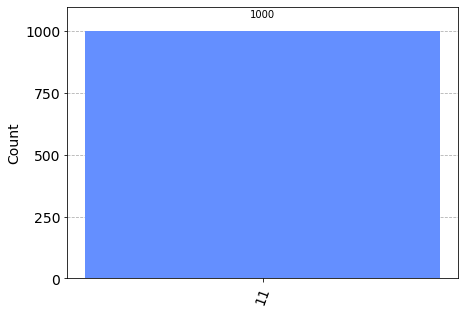

In [21]:
aer_backend = Aer.get_backend('aer_simulator')
job = execute(dj_circuit, aer_backend, shots=1000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
job = execute(dj_circuit, real_backend, shots=1000)
job_monitor(job, interval=2)

Job Status: job is queued (7)     

In [ ]:
# Get the results of the computation
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

In [93]:
qr = QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_results = real_backend.run(meas_calibs, shots=10000).result()

In [95]:
cal_results.get_counts()

[{'00': 9619, '01': 136, '10': 244, '11': 1},
 {'00': 112, '01': 9715, '10': 2, '11': 171},
 {'00': 158, '01': 4, '10': 9691, '11': 147},
 {'00': 1, '01': 154, '10': 100, '11': 9745}]

In [51]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [52]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

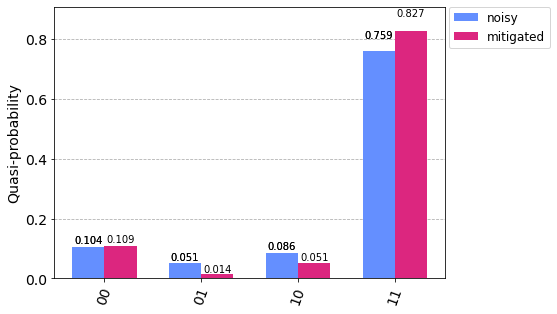

In [53]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

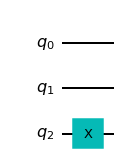

In [21]:
# general
oracle_qc.draw()

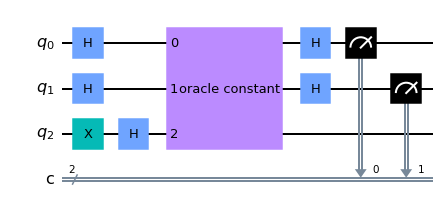

In [22]:
dj_circuit.draw()

In [41]:
n = 2

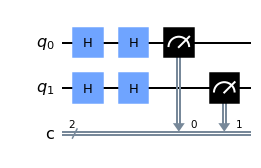

In [42]:
# not calibrating ancilla
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)

dj_left0.h(0)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.h(1)
dj_left0.measure([0,1], [0,1])
dj_left0.draw()

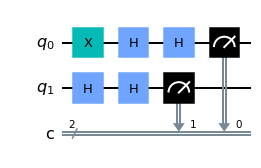

In [43]:
dj_left1 = QuantumCircuit(n, n)
dj_left1.x(0)
dj_left1.h(0)

dj_left1.h(0)
dj_left1.h(1)
dj_left1.h(1)
dj_left1.measure([0,1], [0,1])
dj_left1.draw()

/tmp/ipykernel_2880/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


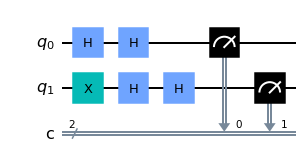

In [44]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_2880/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


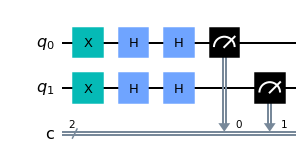

In [45]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

In [46]:
job = execute(dj_left0, real_backend, shots=1000)
results = job.result()
counts = results.get_counts()

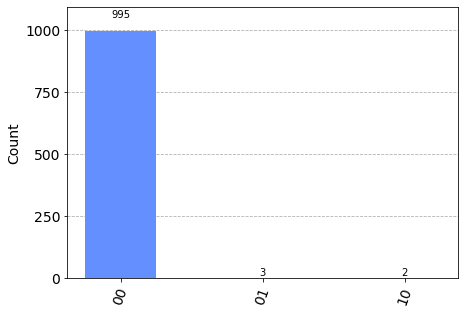

In [48]:
plot_histogram(counts)

In [49]:
array0 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
array0 = array0/1000
array0

array([0.995, 0.003, 0.002, 0.   ])

In [50]:
job = execute(dj_left1, real_backend, shots=1000)
results = job.result()
counts = results.get_counts()

Traceback (most recent call last):
  Input In [50] in <cell line: 2>
    results = job.result()
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/job/ibmqjob.py:279 in result
    raise IBMQJobInvalidStateError('Unable to retrieve result for job {}. '
IBMQJobInvalidStateError: 'Unable to retrieve result for job 63921849d65d0d16eb038d09. Job was cancelled.'

Use %tb to get the full traceback.


In [51]:
results

Result(backend_name='ibmq_belem', backend_version='1.0.53', qobj_id='deb3a865-9062-49e0-9f4c-db68aac8f310', job_id='6392170a0c52a7d0670e10e4', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 995, '0x1': 3, '0x2': 2}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1]], creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, metadata={}, n_qubits=5, name='circuit-105', qreg_sizes=[['q', 5]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4]]), status=done)], date=2022-12-08 16:58:40+00:00, status=Successful completion, header=QobjHeader(backend_name='ibmq_belem', backend_version='1.0.53'), execution_id='8fa3a4a8-7719-11ed-bdd6-b02628f7f59e', time_taken=2.003633975982666, error=None, client_version={'qiskit': '0.39.2'})

In [52]:
print(counts)

{'00': 995, '01': 3, '10': 2}


In [53]:
array1 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
array1 = array1/1000
array1

array([0.995, 0.003, 0.002, 0.   ])

In [ ]:
job = execute(dj_left2, real_backend, shots=1000)
results = job.result()
counts = results.get_counts()

In [ ]:
array2 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
array2 = array2/1000
array2

In [ ]:
job = execute(dj_left3, real_backend, shots=1000)
results = job.result()
counts = results.get_counts()

In [ ]:
array3 = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
array3 = array3/1000
array3

In [85]:
array_left = np.array([array0, array1, array2, array3])

In [54]:
array_left = np.array([array0, array0, array0, array0])

In [55]:
array_right = array_left

In [56]:
calib_mat = (array_left + array_right) / 2

In [57]:
array_to_latex(calib_mat)

<IPython.core.display.Latex object>

In [22]:
qr = QuantumRegister(2)
meas_cabs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [19]:
meas_calibs = [dj_left0, dj_left1, dj_left2, dj_left3]
print(type(meas_calibs))

<class 'list'>


In [20]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit circuit-100
     ┌───┐┌───┐┌─┐   
q_0: ┤ H ├┤ H ├┤M├───
     ├───┤├───┤└╥┘┌─┐
q_1: ┤ H ├┤ H ├─╫─┤M├
     └───┘└───┘ ║ └╥┘
c_0: ═══════════╩══╬═
                   ║ 
c_1: ══════════════╩═
                     

Circuit circuit-104
     ┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ H ├┤ H ├┤M├
     ├───┤├───┤└┬─┬┘└╥┘
q_1: ┤ H ├┤ H ├─┤M├──╫─
     └───┘└───┘ └╥┘  ║ 
c_0: ════════════╬═══╩═
                 ║     
c_1: ════════════╩═════
                       

Circuit circuit-102
     ┌───┐┌───┐     ┌─┐   
q_0: ┤ H ├┤ H ├─────┤M├───
     ├───┤├───┤┌───┐└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘ ║ └╥┘
c_0: ════════════════╩══╬═
                        ║ 
c_1: ═══════════════════╩═
                          

Circuit circuit-103
     ┌───┐┌───┐┌───┐┌─┐   
q_0: ┤ X ├┤ H ├┤ H ├┤M├───
     ├───┤├───┤├───┤└╥┘┌─┐
q_1: ┤ X ├┤ H ├┤ H ├─╫─┤M├
     └───┘└───┘└───┘ ║ └╥┘
c_0: ════════════════╩══╬═
                        ║ 
c_1: ═══════════════════╩═
                          



In [21]:
aer_sim = Aer.get_backend("aer_simulator")
cal_results = aer_sim.run(meas_calibs, shots=10000).result()

In [24]:
state_labels = ['00', '01', '10', '11']

In [27]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='circuit')
# , circlabel='mcal'
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

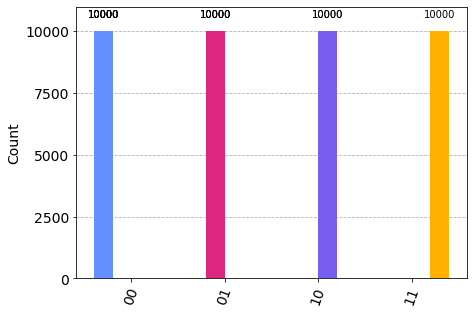

In [26]:
plot_histogram(cal_results.get_counts())

In [ ]:
real_results = execute(meas_calibs, real_backend, shots=10000).result()

In [ ]:

meas_fitter = CompleteMeasFitter(real_results, state_labels)
array_to_latex(meas_fitter.cal_matrix)

In [59]:
real_results = results

In [60]:
# result_submissions = job.result()
# array = np.empty((4,4))
# print(array)
ls = []
# array = np.empty(shape=(4,4))
for qc in meas_calibs:
     counts = real_results.get_counts(qc)
     this_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     # np.append(array, this_array, axis=1)
array = np.array(ls)
print(array)
array_t = np.transpose(array)
print(array_t)

Traceback (most recent call last):
  Input In [60] in <cell line: 6>
    counts = real_results.get_counts(qc)
  File /opt/conda/lib/python3.8/site-packages/qiskit/result/result.py:269 in get_counts
    exp = self._get_experiment(key)
  File /opt/conda/lib/python3.8/site-packages/qiskit/result/result.py:380 in _get_experiment
    raise QiskitError('Data for experiment "%s" could not be found.' % key)
QiskitError: 'Data for experiment "circuit-100" could not be found.'

Use %tb to get the full traceback.


In [80]:
array_to_latex(array)

<IPython.core.display.Latex object>

In [91]:
import scipy.linalg as la
array_inv = la.inv(array_t)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

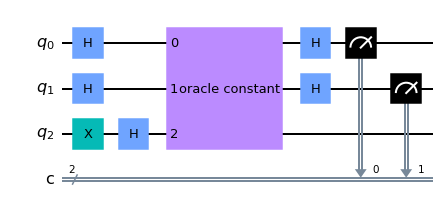

In [98]:
dj_circuit.draw()

In [100]:
job = execute(dj_circuit, real_backend, shots=1000)
results = job.result()
counts = results.get_counts()


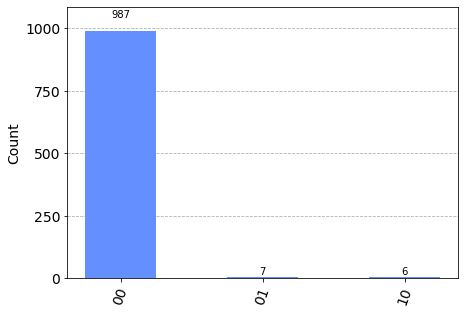

In [101]:
plot_histogram(counts)

In [104]:
result_array = np.array([counts.get('00') or 0, counts.get('01') or 0, counts.get('10') or 0, counts.get('11') or 0])
result_array = result_array/1000

In [105]:
result_array

array([0.987, 0.007, 0.006, 0.   ])

In [28]:
import scipy

In [33]:
mitigated = np.array([1.01422, -0.00412, -0.01017, 0.00007], dtype='f')

In [106]:
mitigated = np.dot(array_inv, result_array)

In [34]:
array_to_latex(mitigated)

Traceback (most recent call last):
  Input In [34] in <cell line: 1>
    array_to_latex(mitigated)
  File /opt/conda/lib/python3.8/site-packages/qiskit/visualization/array.py:242 in array_to_latex
    outstr = _matrix_to_latex(array, precision=precision, prefix=prefix, max_size=max_size)
  File /opt/conda/lib/python3.8/site-packages/qiskit/visualization/array.py:173 in _matrix_to_latex
    out_string += _rows_to_latex([matrix], max_width)
  File /opt/conda/lib/python3.8/site-packages/qiskit/visualization/array.py:163 in _rows_to_latex
    row_string += _elements_to_latex(r)
  File /opt/conda/lib/python3.8/site-packages/qiskit/visualization/array.py:152 in _elements_to_latex
    num_string = _num_to_latex(el, precision=precision)
  File /opt/conda/lib/python3.8/site-packages/qiskit/visualization/array.py:94 in _num_to_latex
    realstring = _proc_value(r)
  File /opt/conda/lib/python3.8/site-packages/qiskit/visualization/array.py:75 in _proc_value
    frac = Fraction(val).limit_denomina

In [109]:
# def NormalizeData(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))
# NormalizeData(mitigated)
# https://www.stackvidhya.com/how-to-normalize-data-between-0-and-1-range/

array([1.        , 0.00590772, 0.        , 0.00999347])

In [111]:
v2 = (mitigated + 0) / sum(mitigated + 0)

In [112]:
v2

array([ 1.01422444e+00, -4.11934404e-03, -1.01711818e-02,  6.60872485e-05])

In [47]:
print(type(array))

<class 'numpy.ndarray'>


In [68]:
cal_results.get_counts()

[{'00': 10000}, {'01': 10000}, {'10': 10000}, {'11': 10000}]

In [69]:
state_labels = ['00', '01', '10', '11']

In [ ]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)
# print(type(meas_fitter.cal_matrix))

In [20]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

Traceback (most recent call last):
  Input In [20] in <cell line: 5>
    mitigated_results = meas_filter.apply(results)
NameError: name 'results' is not defined

Use %tb to get the full traceback.


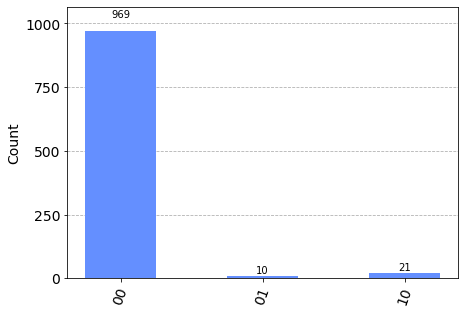

In [57]:
plot_histogram(counts)

In [26]:
#3 qubits balanced and constant, qiskit

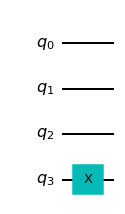

In [54]:
n = 3
oracle_qc = dj_oracle('constant', n)
oracle_qc.draw()

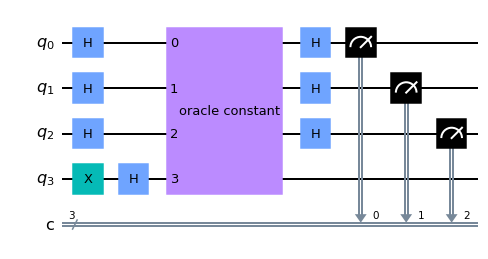

In [55]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

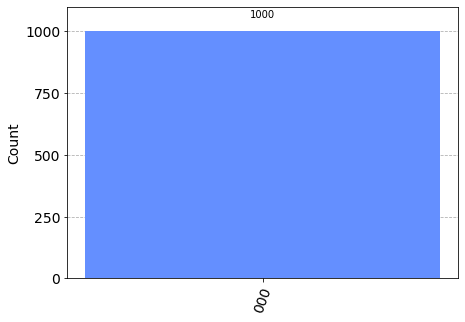

In [56]:
aer_backend = Aer.get_backend('aer_simulator')
job = execute(dj_circuit, aer_backend, shots=1000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [57]:
job = execute(dj_circuit, real_backend, shots=1000)
job_monitor(job, interval=2)

Job Status: job has successfully run


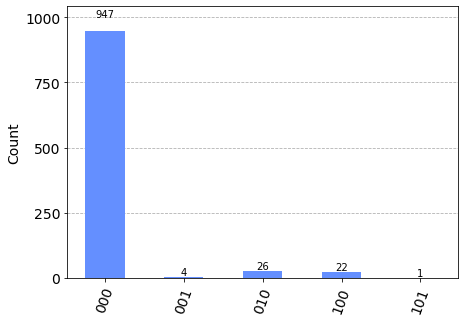

In [58]:
# Get the results of the computation
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

In [ ]:
qr = QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_results = real_backend.run(meas_calibs, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

In [37]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

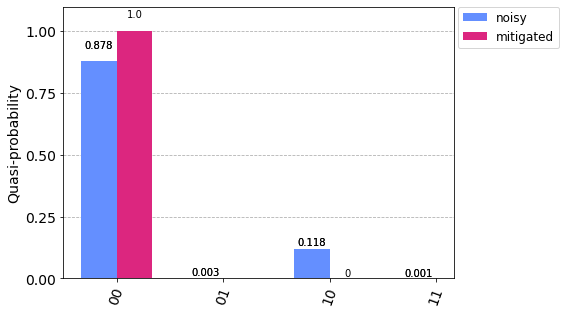

In [38]:
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

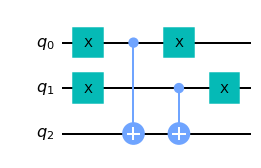

In [45]:
oracle_qc = dj_oracle('balanced', n)
oracle_qc.draw()

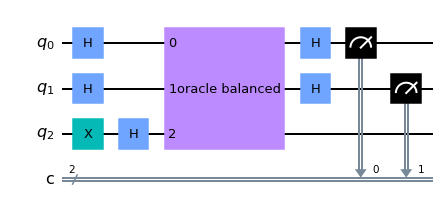

In [46]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

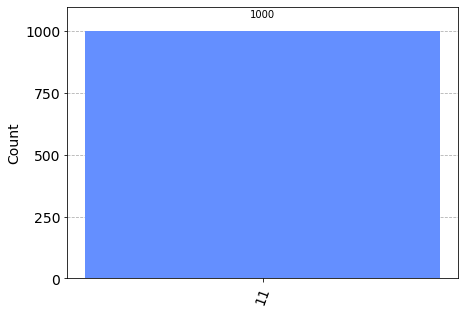

In [47]:
aer_backend = Aer.get_backend('aer_simulator')
job = execute(dj_circuit, aer_backend, shots=1000)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [48]:
job = execute(dj_circuit, real_backend, shots=1000)
job_monitor(job, interval=2)

Job Status: job has successfully run


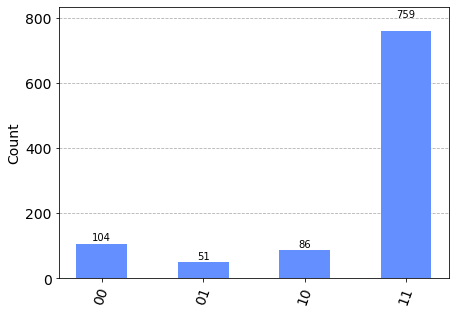

In [49]:
# Get the results of the computation
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

In [50]:
qr = QuantumRegister(n)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_results = real_backend.run(meas_calibs, shots=10000).result()

In [51]:

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [52]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

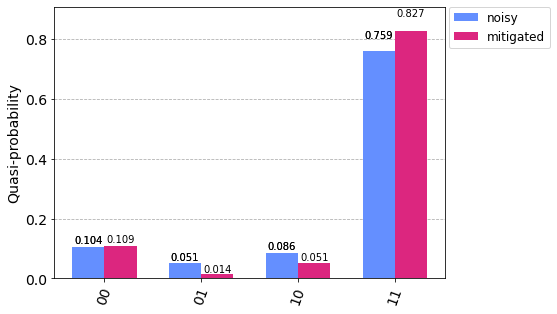

In [53]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [ ]:
# 3 qubits general

In [ ]:
#4 qubits balanced and constant, qiskit

In [ ]:
# 4 qubits general